In [1]:
import re
import pandas as pd
import numpy as np
import statsmodels.api as sm  # for datasets
import matplotlib.pyplot as plt
%matplotlib inline

# Hide Numpy warnings from Statsmodels
import warnings
warnings.filterwarnings('ignore')

# Sequence of Appelpy imports
from appelpy.eda import statistical_moments
from appelpy.utils import DummyEncoder
from appelpy.linear_model import OLS
from appelpy.diagnostics import heteroskedasticity_test

This notebook shows how to make a simple **model pipeline** with Appelpy, using the [Cars93 dataset](https://stat.ethz.ch/R-manual/R-devel/library/MASS/html/Cars93.html).

There is data available about 93 cars.  One variable of interest to model is the price of the cars.

It can be particularly challenging to fit models with many **categorical variables**.  If you fit models on data that come from a database, where categories of a variable may shift over time, then model pipelines can help to make the modelling process more robust and easier to maintain.

**Notebook workflow:**
- Load data
- Explore data
- Transform data (set up functions for transforming the raw data)
    - Column renaming
    - Dummy column encoding
    - Log variables
- Fit model
    - Initial model: set up a basic `ModelPipeline` and fit `model1` using it.  Run model diagnostics.
    - Second model: fit `model2` with the pipeline.  Run model diagnostics.
    - Second model with different base levels for categorical variables.

# Load data

In [2]:
df_raw = sm.datasets.get_rdataset('Cars93', 'MASS').data

In [3]:
df_raw.shape

(93, 27)

# Explore data

In [4]:
statistical_moments(df_raw)

,mean,var,skew,kurtosis
Min.Price,17.1258,76.493,1.16382,0.9016
Price,19.5097,93.3046,1.50824,3.18369
Max.Price,21.8989,121.671,2.00091,6.9816
MPG.city,22.3656,31.5823,1.67682,3.72841
MPG.highway,29.086,28.4273,1.20997,2.41192
EngineSize,2.66774,1.07612,0.845494,0.297016
Horsepower,143.828,2743.08,0.936308,0.98822
RPM,5280.65,356089,-0.254344,-0.451623
Rev.per.mile,2332.2,246519,0.276984,0.145034
Fuel.tank.capacity,16.6645,10.7543,0.106394,0.0566398


Exploratory data analysis and causal reasoning are not the focus of this notebook.

We are interested in **modelling the `Price` of cars based on these independent variables:**
- `Type` (categorical variable)
- `MPG.city` (continuous variable)
- `Airbags` (categorical variable)
- `Origin` (categorical variable)

# Transform data

## Rename columns

The source dataset has columns in camel case.  As we're using Python let's get it closer to **snake case**.

In [5]:
def _rename_columns(df):
    "Make column names lowercase and more like snake-case."
    return (df
            .rename(columns=lambda x: re.sub("[ ,.,-]", '_', x))
            .rename(columns=str.lower))

In [6]:
df_raw.columns

Index(['Manufacturer', 'Model', 'Type', 'Min.Price', 'Price', 'Max.Price',
       'MPG.city', 'MPG.highway', 'AirBags', 'DriveTrain', 'Cylinders',
       'EngineSize', 'Horsepower', 'RPM', 'Rev.per.mile', 'Man.trans.avail',
       'Fuel.tank.capacity', 'Passengers', 'Length', 'Wheelbase', 'Width',
       'Turn.circle', 'Rear.seat.room', 'Luggage.room', 'Weight', 'Origin',
       'Make'],
      dtype='object')

In [7]:
df_raw = df_raw.pipe(_rename_columns)

Clean the column names by using the `rename_columns` method.

In [8]:
df_raw.columns

Index(['manufacturer', 'model', 'type', 'min_price', 'price', 'max_price',
       'mpg_city', 'mpg_highway', 'airbags', 'drivetrain', 'cylinders',
       'enginesize', 'horsepower', 'rpm', 'rev_per_mile', 'man_trans_avail',
       'fuel_tank_capacity', 'passengers', 'length', 'wheelbase', 'width',
       'turn_circle', 'rear_seat_room', 'luggage_room', 'weight', 'origin',
       'make'],
      dtype='object')

## Encoding of columns

There are many categorical variables in the dataset, so for a linear regression model we will need to encode dummy variables from each categorical variable.

In [9]:
def _process_data(raw_df, cat_base_levels):
    "Transform raw dataset by encoding columns, e.g. dummy columns from categorical variables."
    return (df_raw
            .pipe(_rename_columns)
            .pipe(DummyEncoder,
                  categorical_col_base_levels=cat_base_levels)
            .transform()
            .pipe(_rename_columns))

Here is an example of a categorical variable in the dataset and its values:

In [10]:
df_raw['airbags'].unique()

array(['None', 'Driver & Passenger', 'Driver only'], dtype=object)

The raw dataset comes with category values that have capital letters and whitespace.  When encoding dummy columns from them, it is desirable to have the new columns as close to snake case as possible.  The **encoder** will process the columns so that they are more like snake case.

For demonstration, see the columns from a transformed dataset below.

In [11]:
df_raw.pipe(_process_data, {'type': 'Compact',
                            'airbags': 'None',
                            'origin': 'USA'}).columns

Index(['manufacturer', 'model', 'min_price', 'price', 'max_price', 'mpg_city',
       'mpg_highway', 'drivetrain', 'cylinders', 'enginesize', 'horsepower',
       'rpm', 'rev_per_mile', 'man_trans_avail', 'fuel_tank_capacity',
       'passengers', 'length', 'wheelbase', 'width', 'turn_circle',
       'rear_seat_room', 'luggage_room', 'weight', 'make', 'type_large',
       'type_midsize', 'type_small', 'type_sporty', 'type_van',
       'airbags_driver_&_passenger', 'airbags_driver_only', 'origin_non_usa'],
      dtype='object')

## Log variables

Create a basic function for generating log transformations of variables.  This will be particularly useful for positively-skewed variables.

In [12]:
def _create_log_variables(raw_df, cols_list):
    "Transform dataset to include log variables of the variables in cols_list."
    df = raw_df.copy()
    for col in cols_list:
        df['ln_' + col] = np.log(df[col])
    return df

These data cleaning functions could be gathered in a specific class, e.g. `Transformer`.

# Fit model

## Initial model

Let's set out these key things for a linear model, from the raw dataset:
- Dependent variable (`raw_y_list`)
- Independent variables (`raw_X_list`) and the base levels for the categorical variables.

In [13]:
raw_y_list = ['price']
raw_X_list = ['type', 'mpg_city', 'airbags', 'origin']
cat_base_levels = {'type': 'Compact',
                   'airbags': 'None',
                   'origin': 'USA'}

Notice how many of the variables in `raw_X_list` are categorical variables.

In [14]:
df_raw[raw_X_list].dtypes

type        object
mpg_city     int64
airbags     object
origin      object
dtype: object

In [15]:
df_raw[raw_X_list].nunique()

type         6
mpg_city    21
airbags      3
origin       2
dtype: int64

One trick is to make another representation of the independent variables – an X_list – where the categorical variables have the `DummyEncoder` separator appended to them.

In [16]:
[str(x + '_') if x in cat_base_levels.keys()
 else x for x in raw_X_list]

['type_', 'mpg_city', 'airbags_', 'origin_']

### `ModelPipeline`

We can transform the raw dataset, given lists of its y & X variables (and base levels), and make a dataset to use for modelling.

Let's set up a **`ModelPipeline` class**, which takes those variables from the raw dataset and does the following:
- Get a final dataset to use for modelling (`get_dataset` method)
- Get an Appelpy model object that consumes the final dataset (`get_model` method).

In [17]:
class ModelPipeline:
    def __init__(self, raw_df, raw_y_list, raw_X_list, cat_base_levels):
        self.raw_df = raw_df
        self.raw_y_list = raw_y_list
        self.raw_X_list = raw_X_list
        self.cat_base_levels = cat_base_levels

        # Transformed dataset and its columns
        self.df = None
        self.y_list = None
        self.X_list = None

    def get_dataset(self):
        "Return processed dataset, ready to use for modelling"
        df = (self.raw_df
              .pipe(_process_data, self.cat_base_levels)
              .pipe(_create_log_variables, ['price', 'mpg_city']))

        # Append separator to columns that represent categorical variables: 
        X_list_prefixes = [str(x + '_') if x in self.cat_base_levels.keys()
                           else x for x in self.raw_X_list]

        # Get column names to use in model dataset:
        self.y_list = self.raw_y_list
        self.X_list = df.columns[df.columns.str.startswith(tuple(X_list_prefixes))]
        # and filter the source dataset on those columns:
        filter_condition = df.columns.str.startswith(tuple([*self.y_list, *self.X_list]))
        self.df = df.loc[:, filter_condition]
        return self.df

    def get_model(self):
        "Return OLS Appelpy model instance (not fitted)"
        if self.df:
            return OLS(self.df, self.y_list, self.X_list)
        else:
            self.df = self.get_dataset()
            return OLS(self.df, self.y_list, self.X_list)

This is useful, as it will make it easier to run different specifications of models and inspect the dataset used for modelling.

### Model results

In [18]:
model1 = (ModelPipeline(df_raw, raw_y_list, raw_X_list, cat_base_levels)
          .get_model()
          .fit())
model1.results_output

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     14.79
Date:                Fri, 03 Jan 2020   Prob (F-statistic):           5.17e-14
Time:                        21:40:32   Log-Likelihood:                -297.87
No. Observations:                  93   AIC:                             615.7
Df Residuals:                      83   BIC:                             641.1
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         29.6931      4.723      6.288      0.000      20.300      39.086
mpg_city                      -0.7957      0.191     -4.162      0.000      -1.176      -0.415
type_large                     3.0755      2.774      1.109      0.271      -2.442       8.593
type_midsize                   5.1573      2.183      2.362      0.020       0.815       9.499
type_small                    -0.2819      2.598     -0.109      0.914      -5.449       4.885
type_sporty                    0.3151      2.329      0.135      0.893      -4.318       4.948
type_van                      -0.8718      2.904     -0.300      0.765      -6.647       4.903
airbags_driver_&_passenger     8.9089      2.284      3.900      0.000       4.365      13.452
airbags_driver_only            4.5643      1.672      2.730      0.008       1.239       7.890
origin_non_usa                 5.1411      1.439      3.573      0.001       2.280       8.003
==============================================================================
Omnibus:                       43.351   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              123.544
Skew:                           1.620   Prob(JB):                     1.49e-27
Kurtosis:                       7.624   Cond. No.                         195.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
model1.results_output_standardized

,coef,t,P>|t|,coef_stdX,coef_stdXy,stdev_X
price,,,,,,
mpg_city,-0.7957,-4.162,0.000,-4.4719,-0.4630,5.6198
type_large,+3.0755,+1.109,0.271,+0.9986,+0.1034,0.3247
type_midsize,+5.1573,+2.362,0.020,+2.2036,+0.2281,0.4273
type_small,-0.2819,-0.109,0.914,-0.1185,-0.0123,0.4204
type_sporty,+0.3151,+0.135,0.893,+0.1133,+0.0117,0.3595
type_van,-0.8718,-0.300,0.765,-0.2591,-0.0268,0.2973
airbags_driver_&_passenger,+8.9089,+3.900,0.000,+3.3806,+0.3500,0.3795
airbags_driver_only,+4.5643,+2.730,0.008,+2.2880,+0.2369,0.5013
origin_non_usa,+5.1411,+3.573,0.001,+2.5831,+0.2674,0.5024


Access the dataset used for modelling from the model pipeline.

In [20]:
df = (ModelPipeline(df_raw, raw_y_list, raw_X_list, cat_base_levels)
      .get_dataset())

In [21]:
df.head(10)

,price,mpg_city,type_large,type_midsize,type_small,type_sporty,type_van,airbags_driver_&_passenger,airbags_driver_only,origin_non_usa
0,15.9,25,0,0,1,0,0,0,0,1
1,33.9,18,0,1,0,0,0,1,0,1
2,29.1,20,0,0,0,0,0,0,1,1
3,37.7,19,0,1,0,0,0,1,0,1
4,30.0,22,0,1,0,0,0,0,1,1
5,15.7,22,0,1,0,0,0,0,1,0
6,20.8,19,1,0,0,0,0,0,1,0
7,23.7,16,1,0,0,0,0,0,1,0
8,26.3,19,0,1,0,0,0,0,1,0
9,34.7,16,1,0,0,0,0,0,1,0


### Model diagnostics

Let's gather the main residual plots in one place and examine whether the assumptions of OLS hold in the model.

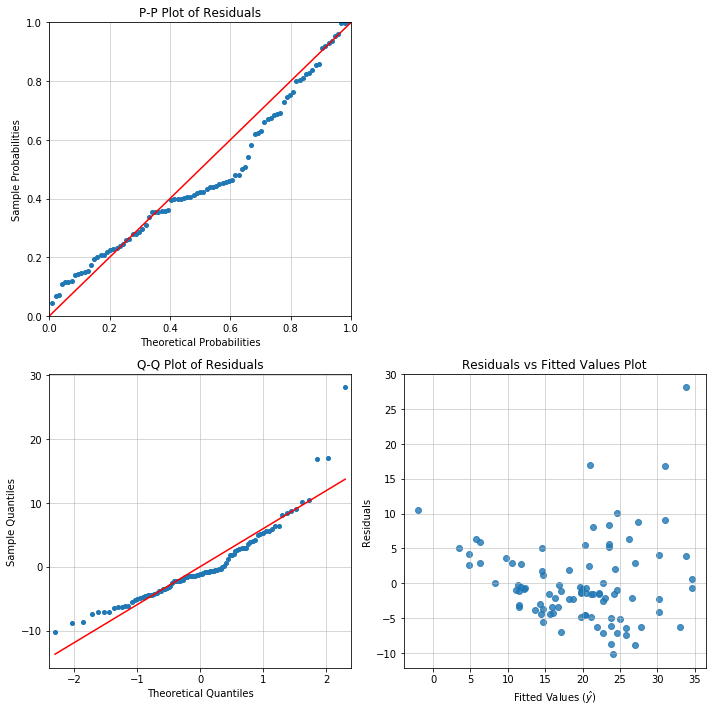

In [22]:
fig, axarr = plt.subplots(2, 2, figsize=(10, 10))
model1.diagnostic_plot('pp_plot', ax=axarr[0][0])
model1.diagnostic_plot('qq_plot', ax=axarr[1][0])
model1.diagnostic_plot('rvf_plot', ax=axarr[1][1])
axarr[0, 1].axis('off')
plt.tight_layout()

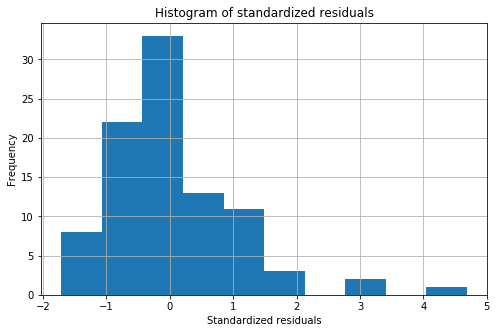

In [23]:
fig, ax = plt.subplots(figsize=(8, 5))
model1.resid_standardized.hist(ax=ax)
ax.set_title('Histogram of standardized residuals')
ax.set_xlabel('Standardized residuals')
ax.set_ylabel('Frequency')
plt.show()

From the residual plots, it is clear that the assumptions of OLS do not hold in the model:
- Residuals are not normally distributed (for y-values close to mean and ones near the tails)
- RVF plot has a funnel pattern.  Perhaps there is heteroskedasticity in the dataset.

In [24]:
bps_stats = heteroskedasticity_test('breusch_pagan_studentized', model1)
print('Breusch-Pagan test (studentized) :: {}'.format(bps_stats['distribution'] + '({})'.format(bps_stats['nu'])))
print('Test statistic: {:.4f}'.format(bps_stats['test_stat']))
print('Test p-value: {:.4f}'.format(bps_stats['p_value']))

Breusch-Pagan test (studentized) :: chi2(1)
Test statistic: 10.6543
Test p-value: 0.3002


## Second model

The functional form of the first model may be inappropriate.

In the statistical moments dataframe we see that the dependent variable `price` is positively skewed.  The model estimates were worst at the tail end of the `price` distribution and the residuals did not appear normally distributed.

Let's use the log-transformed price (`ln_price`) as the dependent variable in a second model.

In [25]:
def log_plots(df, col, figsize=(11,5)):    
    plot_df = (df[col].to_frame()
               .pipe(_create_log_variables, [col]))
    
    fig, axarr = plt.subplots(1, 2, figsize=figsize)
    
    plot_df[col].hist(ax=axarr[0])
    axarr[0].set_title('Histogram of {} values'.format(col))
    axarr[0].set_ylabel('Frequency')
    axarr[0].set_xlabel('Value')
    
    plot_df['ln_' + col].hist(ax=axarr[1])
    axarr[1].set_title('Histogram of ln_{} values'.format(col))
    axarr[1].set_ylabel('Frequency')
    axarr[1].set_xlabel('Value')

    return fig

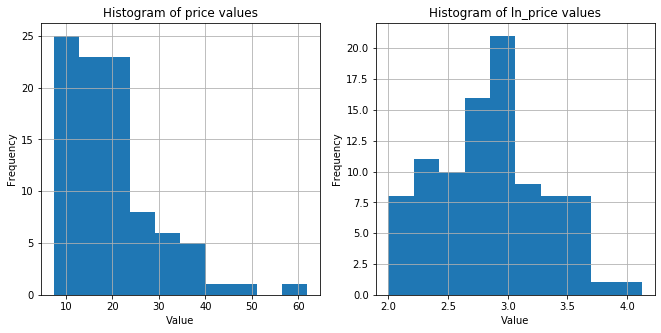

In [26]:
log_plots(df_raw, 'price')
plt.show()

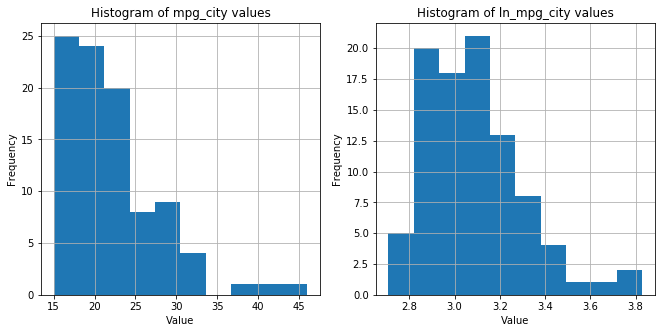

In [27]:
log_plots(df_raw, 'mpg_city')
plt.show()

The log-transforms of the continuous variables in the model have a more normal distribution than their original variables.  However, they still have a slight positive skew.  There are a few particularly influential points in the data.

`model2` arguments

In [28]:
raw_y_list = ['ln_price']
raw_X_list = ['type', 'ln_mpg_city', 'airbags', 'origin']
cat_base_levels = {'type': 'Compact',
                   'airbags': 'None',
                   'origin': 'USA'}

### Model results

In [29]:
model2 = (ModelPipeline(df_raw, raw_y_list, raw_X_list, cat_base_levels)
          .get_model()
          .fit())
model2.results_output

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     34.46
Date:                Fri, 03 Jan 2020   Prob (F-statistic):           1.98e-24
Time:                        21:40:33   Log-Likelihood:                 14.159
No. Observations:                  93   AIC:                            -8.318
Df Residuals:                      83   BIC:                             17.01
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          6.3091      0.559     11.286      0.000       5.197       7.421
type_large                     0.0889      0.099      0.895      0.374      -0.109       0.286
type_midsize                   0.1393      0.078      1.790      0.077      -0.015       0.294
type_small                    -0.1280      0.090     -1.428      0.157      -0.306       0.050
type_sporty                   -0.0140      0.082     -0.172      0.864      -0.176       0.148
type_van                      -0.1196      0.107     -1.114      0.268      -0.333       0.094
airbags_driver_&_passenger     0.3635      0.080      4.550      0.000       0.205       0.522
airbags_driver_only            0.2386      0.058      4.088      0.000       0.122       0.355
origin_non_usa                 0.2322      0.050      4.632      0.000       0.132       0.332
ln_mpg_city                   -1.2106      0.178     -6.789      0.000      -1.565      -0.856
==============================================================================
Omnibus:                        5.184   Durbin-Watson:                   1.891
Prob(Omnibus):                  0.075   Jarque-Bera (JB):                4.821
Skew:                           0.555   Prob(JB):                       0.0898
Kurtosis:                       3.101   Cond. No.                         86.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
model2.results_output_standardized

,coef,t,P>|t|,coef_stdX,coef_stdXy,stdev_X
ln_price,,,,,,
type_large,+0.0889,+0.895,0.374,+0.0289,+0.0635,0.3247
type_midsize,+0.1393,+1.790,0.077,+0.0595,+0.1309,0.4273
type_small,-0.1280,-1.428,0.157,-0.0538,-0.1184,0.4204
type_sporty,-0.0140,-0.172,0.864,-0.0051,-0.0111,0.3595
type_van,-0.1196,-1.114,0.268,-0.0355,-0.0782,0.2973
airbags_driver_&_passenger,+0.3635,+4.550,0.000,+0.1379,+0.3033,0.3795
airbags_driver_only,+0.2386,+4.088,0.000,+0.1196,+0.2630,0.5013
origin_non_usa,+0.2322,+4.632,0.000,+0.1166,+0.2565,0.5024
ln_mpg_city,-1.2106,-6.789,0.000,-0.2710,-0.5961,0.2239


### Model diagnostics

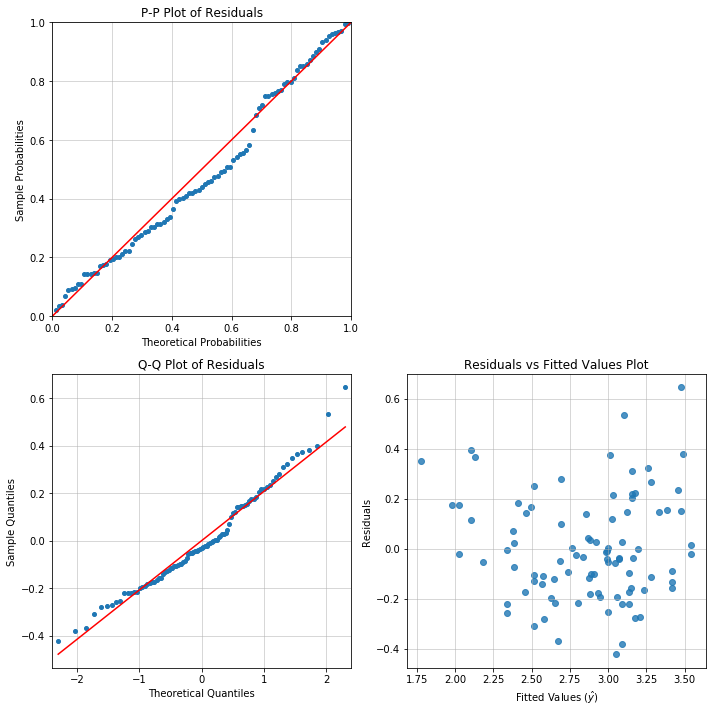

In [31]:
fig, axarr = plt.subplots(2, 2, figsize=(10, 10))
model2.diagnostic_plot('pp_plot', ax=axarr[0][0])
model2.diagnostic_plot('qq_plot', ax=axarr[1][0])
model2.diagnostic_plot('rvf_plot', ax=axarr[1][1])
axarr[0, 1].axis('off')
plt.tight_layout()

The residual plots look much better for this model:
- The residuals are closer to the 45-degree lines in the P-P and Q-Q plots.
- The funnel-like appearance of the RVF plot has disappeared.

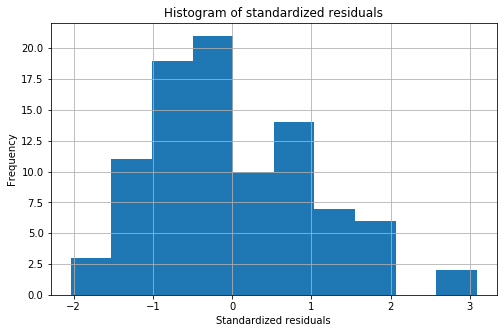

In [32]:
fig, ax = plt.subplots(figsize=(8, 5))
model2.resid_standardized.hist(ax=ax)
ax.set_title('Histogram of standardized residuals')
ax.set_xlabel('Standardized residuals')
ax.set_ylabel('Frequency')
plt.show()

In [33]:
bps_stats = heteroskedasticity_test('breusch_pagan_studentized', model2)
print('Breusch-Pagan test (studentized) :: {}'.format(bps_stats['distribution'] + '({})'.format(bps_stats['nu'])))
print('Test statistic: {:.4f}'.format(bps_stats['test_stat']))
print('Test p-value: {:.4f}'.format(bps_stats['p_value']))

Breusch-Pagan test (studentized) :: chi2(1)
Test statistic: 5.8346
Test p-value: 0.7564


## Second model - change base levels

Suppose we want to run a model with different base levels for the categorical variables.

This is relatively easy now that we have made the `ModelPipeline`.

It's possible to do so without the model pipeline class, e.g. by manually listing the final columns in an `X_list`, but it is difficult to check whether column names are correct or if columns are missing, especially for datasets where there are multiple categorical variables or categorical variables that have multiple values.

Let's set up different base levels for categorical variables in an alternative form of model 2, `model2_alt`.

In [34]:
raw_y_list = ['ln_price']
raw_X_list = ['type', 'ln_mpg_city', 'airbags', 'origin']
cat_base_levels = {'type': 'Small',  # changed level
                   'airbags': 'None',
                   'origin': 'USA'}

In [35]:
model2_alt = (ModelPipeline(df_raw, raw_y_list, raw_X_list, cat_base_levels)
              .get_model()
              .fit())
model2_alt.results_output

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     34.46
Date:                Fri, 03 Jan 2020   Prob (F-statistic):           1.98e-24
Time:                        21:40:34   Log-Likelihood:                 14.159
No. Observations:                  93   AIC:                            -8.318
Df Residuals:                      83   BIC:                             17.01
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          6.1811      0.602     10.271      0.000       4.984       7.378
type_compact                   0.1280      0.090      1.428      0.157      -0.050       0.306
type_large                     0.2169      0.127      1.703      0.092      -0.036       0.470
type_midsize                   0.2673      0.104      2.574      0.012       0.061       0.474
type_sporty                    0.1140      0.099      1.153      0.252      -0.083       0.311
type_van                       0.0085      0.131      0.065      0.949      -0.252       0.269
airbags_driver_&_passenger     0.3635      0.080      4.550      0.000       0.205       0.522
airbags_driver_only            0.2386      0.058      4.088      0.000       0.122       0.355
origin_non_usa                 0.2322      0.050      4.632      0.000       0.132       0.332
ln_mpg_city                   -1.2106      0.178     -6.789      0.000      -1.565      -0.856
==============================================================================
Omnibus:                        5.184   Durbin-Watson:                   1.891
Prob(Omnibus):                  0.075   Jarque-Bera (JB):                4.821
Skew:                           0.555   Prob(JB):                       0.0898
Kurtosis:                       3.101   Cond. No.                         95.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

With the alternative base levels, of course we still have the same model performance (e.g. R-squared) but different dummy columns are shown.

In [36]:
model2_alt.results_output_standardized

,coef,t,P>|t|,coef_stdX,coef_stdXy,stdev_X
ln_price,,,,,,
type_compact,+0.1280,+1.428,0.157,+0.0486,+0.1069,0.3795
type_large,+0.2169,+1.703,0.092,+0.0704,+0.1549,0.3247
type_midsize,+0.2673,+2.574,0.012,+0.1142,+0.2512,0.4273
type_sporty,+0.1140,+1.153,0.252,+0.0410,+0.0901,0.3595
type_van,+0.0085,+0.065,0.949,+0.0025,+0.0055,0.2973
airbags_driver_&_passenger,+0.3635,+4.550,0.000,+0.1379,+0.3033,0.3795
airbags_driver_only,+0.2386,+4.088,0.000,+0.1196,+0.2630,0.5013
origin_non_usa,+0.2322,+4.632,0.000,+0.1166,+0.2565,0.5024
ln_mpg_city,-1.2106,-6.789,0.000,-0.2710,-0.5961,0.2239
